In [3]:
import h5py
import numpy as np
import cv2  # For saving masks (optional)
import os

### Mask generation function

In [ ]:
import numpy as np

def generate_annotation_masks(images, layers, height=None, width=None):
    """
    Generate segmentation masks from ILM, PR1, and BM layer annotations.
    Class 0: Background
    Class 1: ILM to PR1 region
    Class 2: PR1 to BM region
    args:
        images: numpy array of shape (batch_size, height, width, channels)
        layers: dictionary with keys 'ILM', 'PR1', 'BM' containing layer annotations
        height: optional height of the output masks, defaults to images.shape[1]
        width: optional width of the output masks, defaults to images.shape[2]
    returns:
        masks: numpy array of shape (batch_size, height, width) with segmentation masks
    """
    if height is None:
        height = images.shape[1]
    if width is None:
        width = images.shape[2]

    batch_size = images.shape[0]
    masks = np.zeros((batch_size, height, width), dtype=np.uint8)

    for b in range(batch_size):
        
         # Get the layer boundaries for this image
        ilm_line = layers['ILM'][b]
        pr1_line = layers['PR1'][b]
        bm_line = layers['BM'][b]

        # Process each column (x-coordinate)
        for x in range(width):
            # Get y-coordinates for the three layers at this x position
            ilm_y = ilm_line[x]
            pr1_y = pr1_line[x]
            bm_y = bm_line[x]

            if np.isnan(ilm_y) or np.isnan(pr1_y) or np.isnan(bm_y):
                continue

            # Convert to integer pixel coordinates and clip to image bounds
            ilm_y = int(np.clip(round(ilm_y), 0, height-1))
            pr1_y = int(np.clip(round(pr1_y), 0, height-1))
            bm_y = int(np.clip(round(bm_y), 0, height-1))

            # Sort to ensure correct order (top < middle < bottom)
            top, mid, bottom = sorted([ilm_y, pr1_y, bm_y])

            # ILM to PR1 region (Class 1)
            if top < mid:
                masks[b, top:mid, x] = 1
            # PR1 to BM region (Class 2)
            if mid < bottom:
                masks[b, mid:bottom, x] = 2
            # Everything else remains background (Class 0)

    return masks

In [29]:
# Step 1: Load the HDF5 file
def load_h5_data(file_path, target_layers=['ILM', 'PR1', 'BM'], num_samples=3):
    with h5py.File(file_path, 'r') as f:
        # Load only the first num_samples images
        images = f['images'][:num_samples]  # Shape: (num_samples, height, width)
        layer_group = f['layers']
        
        # Filter only the target layers we want
        layers = {}
        for layer_name in target_layers:
            if layer_name in layer_group:
                layers[layer_name] = layer_group[layer_name][:num_samples]  # Shape: (num_samples, 768)
            else:
                print(f"Warning: Layer '{layer_name}' not found in the data")
        
        layer_names = list(layers.keys())
    return images, layers, layer_names

In [8]:
images, layers, layer_names = load_h5_data('/home/suraj/Git/SCR-Progression/Nemours_Jing_RL_Annotated.h5')
#image and layer shapes
print(f"Image shape: {images.shape}")
for layer_name, layer_data in layers.items():
    print(f"Layer '{layer_name}' shape: {layer_data.shape}")

Image shape: (3, 496, 768)
Layer 'ILM' shape: (3, 768)
Layer 'PR1' shape: (3, 768)
Layer 'BM' shape: (3, 768)


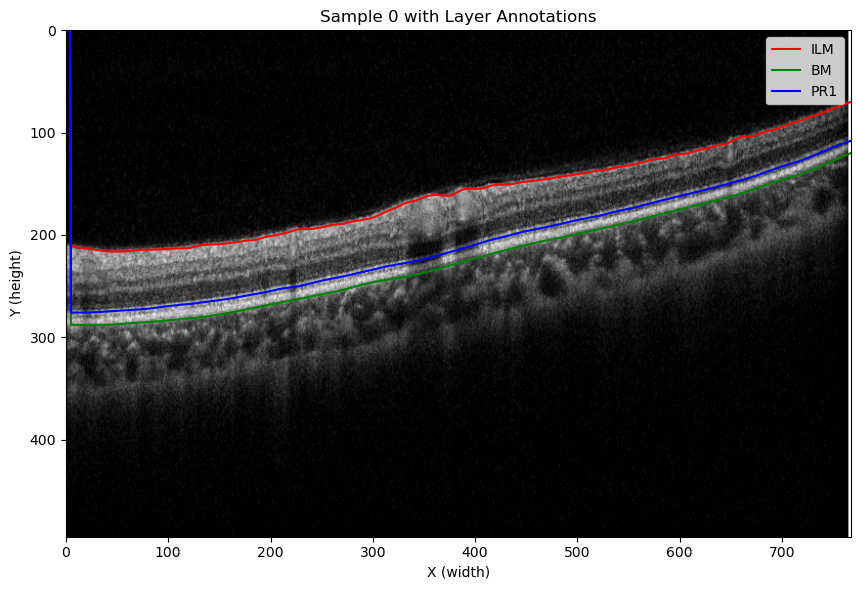

In [30]:
import matplotlib.pyplot as plt

def plot_layer_annotations(images, layers, sample_idx=0):
    """
    Plot the image with ILM, BM, and PR1 layer annotations for a given sample.
    """
    img = images[sample_idx]
    ilm_line = layers['ILM'][sample_idx]
    bm_line = layers['BM'][sample_idx]
    pr1_line = layers['PR1'][sample_idx]
    x_coords = np.arange(img.shape[1])

    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.plot(x_coords, ilm_line, 'r-', label='ILM')
    plt.plot(x_coords, bm_line, 'g-', label='BM')
    plt.plot(x_coords, pr1_line, 'b-', label='PR1')
    plt.title(f"Sample {sample_idx} with Layer Annotations")
    plt.xlabel("X (width)")
    plt.ylabel("Y (height)")
    plt.legend()
    plt.xlim(0, img.shape[1]-1)
    plt.ylim(img.shape[0]-1, 0)  # Flip y-axis to match image orientation
    plt.tight_layout()
    plt.show()

# Plot for sample 0
plot_layer_annotations(images, layers, sample_idx=0)

In [31]:
# Step 2: Generate segmentation masks - Corrected Layer Ordering
def generate_masks(images, layers, layer_names, height=None, width=768):
    if height is None:
        height = images.shape[1]  # Get height from actual image dimensions
        
    batch_size = images.shape[0]
    
    # Initialize segmentation masks: batch_size x height x width
    # Class 0: Background, Class 1: ILM to BM, Class 2: BM to PR1
    segmentation_masks = np.zeros((batch_size, height, width), dtype=np.uint8)
    
    print(f"Creating masks for {batch_size} images of size {height}x{width}")
    
    # Process each image in the batch
    for b in range(batch_size):
        print(f"Processing image {b+1}/{batch_size}")
        
        # Get the layer boundaries for this image
        ilm_line = layers['ILM'][b]      # Shape: (768,) - y-coordinates for each x (topmost)
        bm_line = layers['BM'][b]        # Shape: (768,) - y-coordinates for each x (middle)
        pr1_line = layers['PR1'][b]      # Shape: (768,) - y-coordinates for each x (bottommost)
        
        # Process each column (x-coordinate)
        for x in range(width):
            # Get y-coordinates for the three layers at this x position
            ilm_y = ilm_line[x]    # Topmost layer
            pr1_y = pr1_line[x]    # Bottommost layer
            bm_y = bm_line[x]      # Middle layer  
            
            # Skip if any layer has NaN (no annotation in this region)
            if np.isnan(ilm_y) or np.isnan(pr1_y) or np.isnan(bm_y):
                continue
                
            # Convert to integer pixel coordinates
            ilm_y = int(round(ilm_y))
            pr1_y = int(round(pr1_y))
            bm_y = int(round(bm_y))
            
            # Ensure coordinates are within image bounds
            ilm_y = max(0, min(ilm_y, height-1))
            pr1_y = max(0, min(pr1_y, height-1))
            bm_y = max(0, min(bm_y, height-1))
            
            # Ensure proper ordering: ILM (top) < PR1 (middle) < BM (bottom)
            # Sort the three points to ensure correct ordering
            layer_points = sorted([ilm_y, pr1_y, bm_y])
            top_y, mid_y, bottom_y = layer_points
            
            # Fill the regions:
            # Region 1: From top layer to middle layer (Class 1) - ILM to PR1 region
            if top_y < mid_y:
                segmentation_masks[b, top_y:mid_y, x] = 1

            # Region 2: From middle layer to bottom layer (Class 2) - PR1 to BM region
            if mid_y < bottom_y:
                segmentation_masks[b, mid_y:bottom_y, x] = 2
                
            # Everything else remains Class 0 (background)
        
        # Print some statistics for this image
        unique_classes = np.unique(segmentation_masks[b])
        class_counts = [(cls, np.sum(segmentation_masks[b] == cls)) for cls in unique_classes]
        print(f"  Image {b+1} - Classes and pixel counts: {class_counts}")
    
    return segmentation_masks

In [32]:
# Step 3: Post-process masks (optional)
def smooth_masks(masks, kernel_size=3):
    smoothed_masks = masks.copy()
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for b in range(masks.shape[0]):
        smoothed_masks[b] = cv2.morphologyEx(masks[b], cv2.MORPH_CLOSE, kernel)
    return smoothed_masks

In [33]:
# Main function
def main(h5_file_path):
    print(f"Loading data from: {h5_file_path}")
    
    # Load data (only 3 samples, only ILM, PR1, BM layers)
    images, layers, layer_names = load_h5_data(h5_file_path)
    
    print(f"Loaded {images.shape[0]} images with shape {images.shape}")
    print(f"Processing layers: {layer_names}")
    
    # Generate masks
    multiclass_masks = generate_masks(images, layers, layer_names)
    
    print(f"Generated segmentation masks with shape: {multiclass_masks.shape}")
    
    # Optional: Smooth masks to reduce noise
    multiclass_masks = smooth_masks(multiclass_masks)
    
    # Save masks
    save_masks(multiclass_masks)
    
    return multiclass_masks

In [34]:
if __name__ == "__main__":
    h5_file_path = '/home/suraj/Git/SCR-Progression/e2e/Nemours_Jing_RL_Annotated.h5'
    multiclass_masks = main(h5_file_path)

Loading data from: /home/suraj/Git/SCR-Progression/e2e/Nemours_Jing_RL_Annotated.h5
Loaded 3 images with shape (3, 496, 768)
Processing layers: ['ILM', 'PR1', 'BM']
Creating masks for 3 images of size 496x768
Processing image 1/3
  Image 1 - Classes and pixel counts: [(0, 286587), (1, 31342), (2, 62999)]
Processing image 2/3
  Image 2 - Classes and pixel counts: [(0, 286470), (1, 31481), (2, 62977)]
Processing image 3/3
  Image 3 - Classes and pixel counts: [(0, 286502), (1, 31424), (2, 63002)]
Generated segmentation masks with shape: (3, 496, 768)
Saving 3 sample masks to masks/
Segmentation mask classes (corrected layer order):
  Class 0: Background
  Class 1: ILM to BM region (upper retinal layers)
  Class 2: BM to PR1 region (photoreceptor region)
Unique values in masks: [0 1 2]


In [25]:
# Test the corrected mask generation
print("Testing corrected mask generation...")

# Generate masks with correct layer ordering
corrected_masks = generate_masks(images, layers, layer_names)

print(f"\nCorrected mask shape: {corrected_masks.shape}")
print(f"Unique values across all masks: {np.unique(corrected_masks)}")

# Check each image individually
for i in range(corrected_masks.shape[0]):
    unique_vals, counts = np.unique(corrected_masks[i], return_counts=True)
    total_pixels = corrected_masks[i].shape[0] * corrected_masks[i].shape[1]
    percentages = (counts / total_pixels) * 100
    print(f"Image {i+1}:")
    for cls, count, pct in zip(unique_vals, counts, percentages):
        region_name = ["Background", "ILM-to-BM", "BM-to-PR1"][cls]
        print(f"  Class {cls} ({region_name}): {count} pixels ({pct:.1f}%)")

# Save the corrected masks
save_masks(corrected_masks)

Testing corrected mask generation...
Creating masks for 3 images of size 496x768
Processing image 1/3
  Image 1 - Classes and pixel counts: [(0, 333009), (1, 37837), (2, 10082)]
Processing image 2/3
  Image 2 - Classes and pixel counts: [(0, 332978), (1, 37742), (2, 10208)]
Processing image 3/3
  Image 3 - Classes and pixel counts: [(0, 332809), (1, 38053), (2, 10066)]

Corrected mask shape: (3, 496, 768)
Unique values across all masks: [0 1 2]
Image 1:
  Class 0 (Background): 333009 pixels (87.4%)
  Class 1 (ILM-to-BM): 37837 pixels (9.9%)
  Class 2 (BM-to-PR1): 10082 pixels (2.6%)
Image 2:
  Class 0 (Background): 332978 pixels (87.4%)
  Class 1 (ILM-to-BM): 37742 pixels (9.9%)
  Class 2 (BM-to-PR1): 10208 pixels (2.7%)
Image 3:
  Class 0 (Background): 332809 pixels (87.4%)
  Class 1 (ILM-to-BM): 38053 pixels (10.0%)
  Class 2 (BM-to-PR1): 10066 pixels (2.6%)
Saving 3 sample masks to masks/
Segmentation mask classes (corrected layer order):
  Class 0: Background
  Class 1: ILM to BM r

Visualization saved to: masks/visualization_sample_0.png


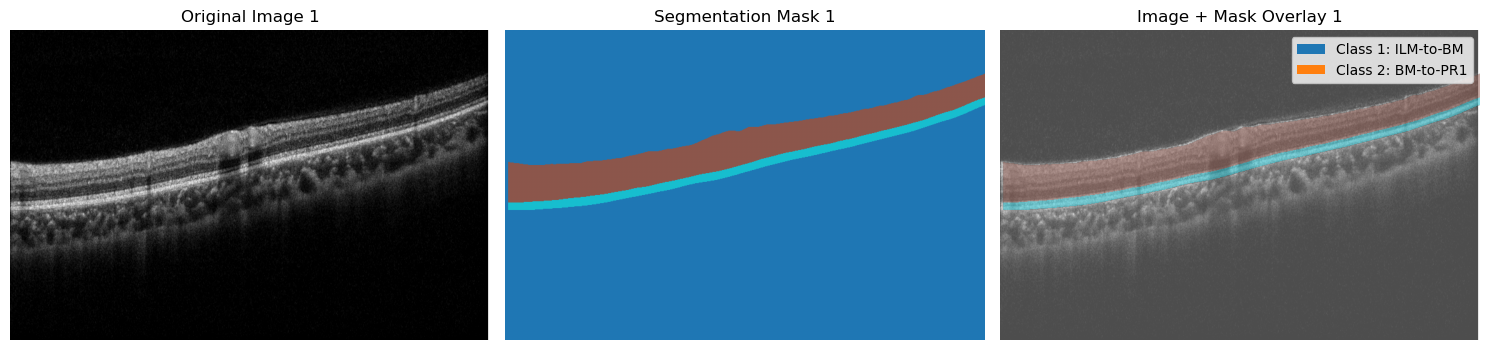

Visualization saved to: masks/visualization_sample_1.png


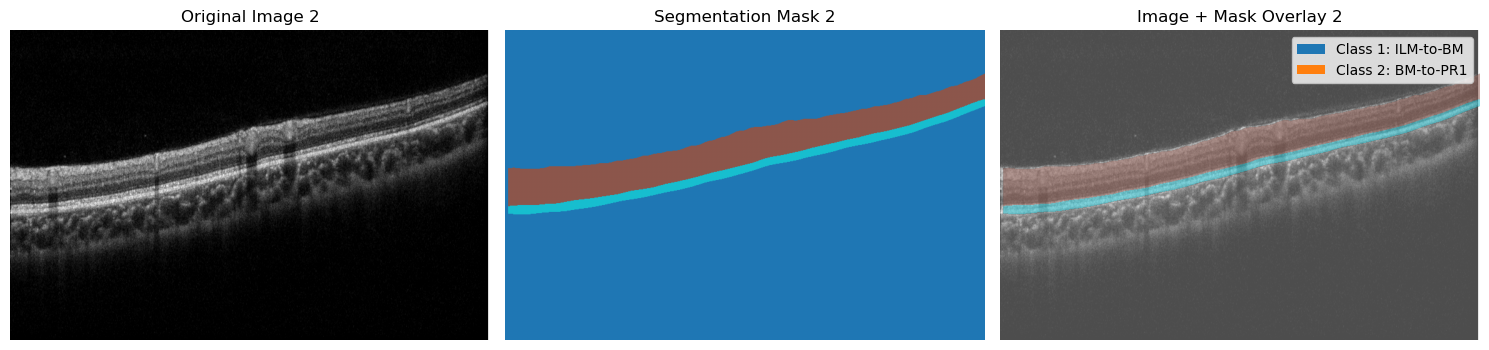

Visualization saved to: masks/visualization_sample_2.png


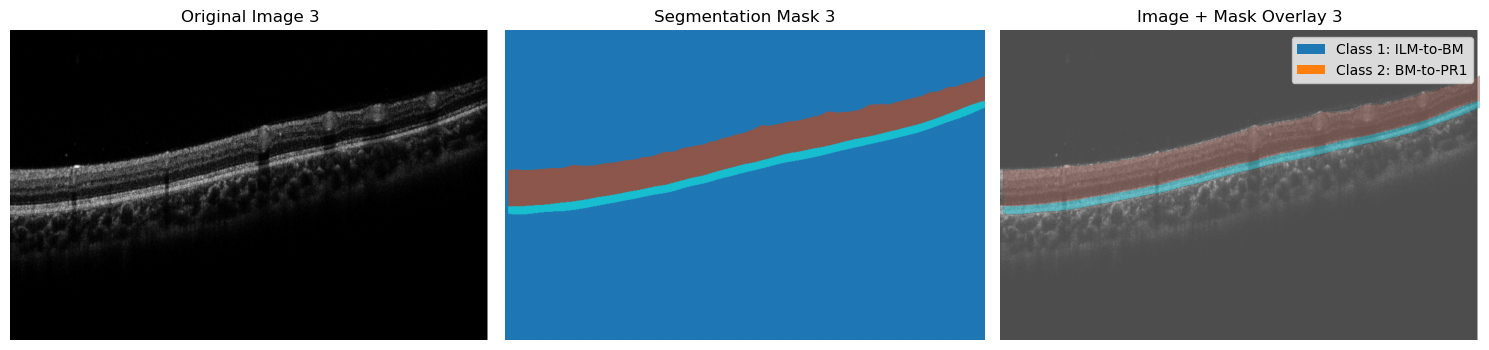

In [26]:
# Visualization function to verify masks
import matplotlib.pyplot as plt

def visualize_masks_and_images(images, masks, sample_idx=0, save_path=None):
    """
    Visualize original image with overlay of segmentation mask and layer boundaries
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(images[sample_idx], cmap='gray')
    axes[0].set_title(f'Original Image {sample_idx+1}')
    axes[0].axis('off')
    
    # Segmentation mask
    axes[1].imshow(masks[sample_idx], cmap='tab10', vmin=0, vmax=2)
    axes[1].set_title(f'Segmentation Mask {sample_idx+1}')
    axes[1].axis('off')
    
    # Overlay: Original image with mask overlay
    axes[2].imshow(images[sample_idx], cmap='gray', alpha=0.7)
    mask_overlay = np.ma.masked_where(masks[sample_idx] == 0, masks[sample_idx])
    axes[2].imshow(mask_overlay, cmap='tab10', alpha=0.5, vmin=0, vmax=2)
    axes[2].set_title(f'Image + Mask Overlay {sample_idx+1}')
    axes[2].axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='tab:blue', label='Class 1: ILM-to-BM'),
        Patch(facecolor='tab:orange', label='Class 2: BM-to-PR1')
    ]
    axes[2].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

# Visualize all 3 samples
for i in range(3):
    visualize_masks_and_images(images, corrected_masks, sample_idx=i, 
                              save_path=f'masks/visualization_sample_{i}.png')

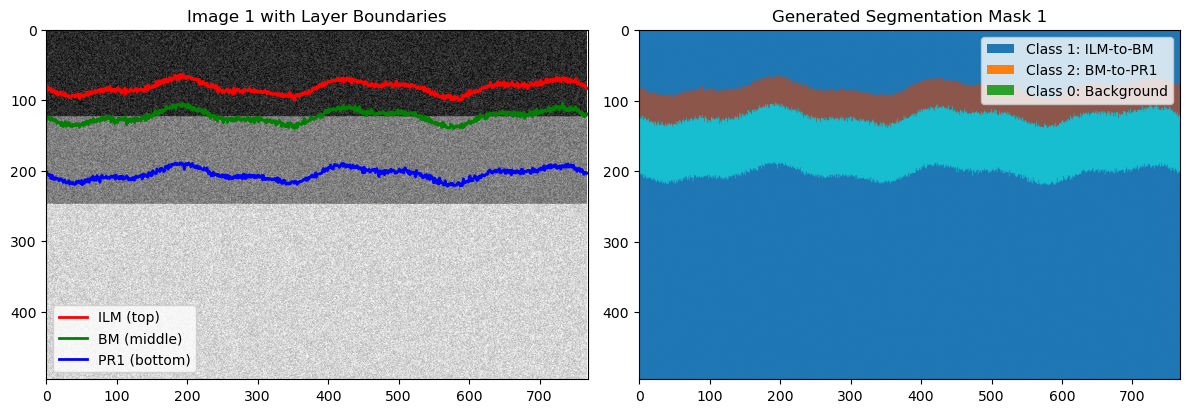

Verification for Image 1:
  Layer ranges (y-coordinates):
    ILM: 62.8 to 100.3
    BM:  103.5 to 140.3
    PR1: 188.8 to 222.0
  Mask statistics:
    Class 0 (Background): 286,587 pixels (75.2%)
    Class 1 (ILM-to-BM): 31,342 pixels (8.2%)
    Class 2 (BM-to-PR1): 62,999 pixels (16.5%)


In [18]:
# Function to verify mask quality by overlaying layer boundaries
def verify_masks_with_boundaries(images, masks, layers, sample_idx=0):
    """
    Verify mask quality by showing original image with layer boundaries and masks
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Original image with layer boundary lines
    axes[0].imshow(images[sample_idx], cmap='gray')
    
    # Draw layer boundaries
    x_coords = np.arange(768)
    ilm_line = layers['ILM'][sample_idx]
    bm_line = layers['BM'][sample_idx]  
    pr1_line = layers['PR1'][sample_idx]
    
    # Only plot where we have valid (non-NaN) values
    valid_mask = ~(np.isnan(ilm_line) | np.isnan(bm_line) | np.isnan(pr1_line))
    
    axes[0].plot(x_coords[valid_mask], ilm_line[valid_mask], 'r-', linewidth=2, label='ILM (top)')
    axes[0].plot(x_coords[valid_mask], bm_line[valid_mask], 'g-', linewidth=2, label='BM (middle)')
    axes[0].plot(x_coords[valid_mask], pr1_line[valid_mask], 'b-', linewidth=2, label='PR1 (bottom)')
    
    axes[0].set_title(f'Image {sample_idx+1} with Layer Boundaries')
    axes[0].legend()
    axes[0].set_xlim(0, 768)
    axes[0].set_ylim(496, 0)  # Flip y-axis to match image orientation
    
    # Plot 2: Segmentation mask
    axes[1].imshow(masks[sample_idx], cmap='tab10', vmin=0, vmax=2)
    axes[1].set_title(f'Generated Segmentation Mask {sample_idx+1}')
    
    # Add colorbar for mask
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='tab:blue', label='Class 1: ILM-to-BM'),
        Patch(facecolor='tab:orange', label='Class 2: BM-to-PR1'),
        Patch(facecolor='tab:green', label='Class 0: Background')
    ]
    axes[1].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print some verification statistics
    print(f"Verification for Image {sample_idx+1}:")
    print(f"  Layer ranges (y-coordinates):")
    print(f"    ILM: {np.nanmin(ilm_line):.1f} to {np.nanmax(ilm_line):.1f}")
    print(f"    BM:  {np.nanmin(bm_line):.1f} to {np.nanmax(bm_line):.1f}")
    print(f"    PR1: {np.nanmin(pr1_line):.1f} to {np.nanmax(pr1_line):.1f}")
    
    unique_vals, counts = np.unique(masks[sample_idx], return_counts=True)
    total_pixels = masks[sample_idx].size
    print(f"  Mask statistics:")
    for cls, count in zip(unique_vals, counts):
        pct = (count / total_pixels) * 100
        region_name = ["Background", "ILM-to-BM", "BM-to-PR1"][cls]
        print(f"    Class {cls} ({region_name}): {count:,} pixels ({pct:.1f}%)")

# Verify one sample
verify_masks_with_boundaries(images, corrected_masks, layers, sample_idx=0)